In [3]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
sns.set(style="ticks")
import gc
import itertools
from datetime import datetime
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter("ignore")
pd.set_option('display.max_columns', 100)
np.random.seed(42)
#import plotly
from datetime import datetime, timedelta
#import plotly.offline as pyoff
#import plotly.graph_objs as go
#initiate visualization library for jupyter notebook 
#from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
#pyoff.init_notebook_mode(connected=True)
%matplotlib inline


In [4]:
# loading data 
customers = pd.read_csv("olist_customers_dataset.csv")
order_items = pd.read_csv("olist_order_items_dataset.csv")
order_payments = pd.read_csv("olist_order_payments_dataset.csv")
orders = pd.read_csv("olist_orders_dataset.csv")
geolocation = pd.read_csv("olist_geolocation_dataset.csv")
reviews = pd.read_csv("olist_order_reviews_dataset.csv")
product = pd.read_csv("olist_products_dataset.csv")
seller = pd.read_csv("olist_sellers_dataset.csv")
translate = pd.read_csv("product_category_name_translation.csv")

In [7]:
df1 = order_items.merge(order_payments, on='order_id')
df2 = df1.merge(orders, on='order_id')
ok = df2.merge(customers, on='customer_id')

print(ok.shape)

(117601, 22)


In [8]:
dates= ['shipping_limit_date', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 
                'order_delivered_customer_date', 'order_estimated_delivery_date']
for col in dates:
    ok[col]= pd.to_datetime(ok[col], format = '%Y-%m-%d %H:%M:%S')

In [9]:

#Let's create a hypothetical snapshot_day data as if we're doing analysis recently#
snapshot_date=max(ok.order_purchase_timestamp) + timedelta(days=10)

In [10]:
ok['total']=ok['order_item_id'] * ok['payment_value']

In [11]:
ok.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,total
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,1,credit_card,2,72.19,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29,871766c5855e863f6eccc05f988b23cb,28013,campos dos goytacazes,RJ,72.19
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,1,credit_card,3,259.83,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15,eb28e67c4c0b83846050ddfb8a35d051,15775,santa fe do sul,SP,259.83
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,1,credit_card,5,216.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05,3818d81c6709e39d06b2738a8d3a2474,35661,para de minas,MG,216.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,1,credit_card,2,25.78,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20,af861d436cfc08b2c2ddefd0ba074622,12952,atibaia,SP,25.78
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,1,credit_card,3,218.04,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17,64b576fb70d441e8f1b2d7d446e483c5,13226,varzea paulista,SP,218.04


In [12]:
datamart = ok.groupby(['customer_unique_id']).agg({
    'order_purchase_timestamp': lambda x: (snapshot_date - x.max()).days,'order_id': 'count', 'total': 'sum'})

In [13]:
# Rename columns for easier interpretation
datamart.rename(columns = {'order_purchase_timestamp': 'Recency',
                           'order_id': 'Frequency',
                           'total': 'MonetaryValue'}, inplace=True)

In [14]:
#Recency quartile
r_labels = range(4, 0, -1)
r_quartiles = pd.qcut(datamart['Recency'], 4, labels = r_labels)
datamart = datamart.assign(R = r_quartiles.values)

In [22]:
f_labels = range(1,5)
f_quartiles = pd.cut(datamart['Frequency'], 4, labels = f_labels,duplicates='drop')
datamart = datamart.assign(F = f_quartiles.values)


In [24]:
#and monetaryvalue quartile
m_labels = range(1,5)
m_quartiles = pd.qcut(datamart['MonetaryValue'], 4, labels = m_labels)
datamart = datamart.assign(M = m_quartiles.values)

In [25]:
datamart.head()

,Recency,Frequency,MonetaryValue,R,F,M
customer_unique_id,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,125,1,141.90,4,1,3
0000b849f77a49e4a4ce2b2a4ca5be3f,128,1,27.19,4,1,1
0000f46a3911fa3c0805444483337064,551,1,86.22,1,1,2
0000f6ccb0745a6a4b88665a16c9f078,335,1,43.62,2,1,1
0004aac84e0df4da2b147fca70cf8255,302,1,196.89,2,1,3


In [26]:
def join_rfm(x): return str(x['R']) + str(x['F']) + str(x['M'])
datamart['RFM_Segment'] = datamart.apply(join_rfm, axis=1)
datamart['RFM_Score'] = datamart[['R','F','M']].sum(axis=1)

In [27]:
datamart.head(10)

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment,RFM_Score
customer_unique_id,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,125,1,141.90,4,1,3,413,8.0
0000b849f77a49e4a4ce2b2a4ca5be3f,128,1,27.19,4,1,1,411,6.0
0000f46a3911fa3c0805444483337064,551,1,86.22,1,1,2,112,4.0
0000f6ccb0745a6a4b88665a16c9f078,335,1,43.62,2,1,1,211,4.0
0004aac84e0df4da2b147fca70cf8255,302,1,196.89,2,1,3,213,6.0
0004bd2a26a76fe21f786e4fbd80607f,160,1,166.98,3,1,3,313,7.0
00050ab1314c0e55a6ca13cf7181fecf,145,1,35.38,3,1,1,311,5.0
00053a61a98854899e70ed204dd4bafe,196,2,1257.54,3,1,4,314,8.0
0005e1862207bf6ccc02e4228effd9a0,557,1,150.12,1,1,3,113,5.0


In [28]:
#largest RFM segments

datamart.groupby('RFM_Segment').size().sort_values(ascending=False)[:10]

RFM_Segment
413    6210
212    6130
112    6117
313    6091
111    6047
311    6033
214    5982
314    5974
414    5968
411    5918
dtype: int64

In [29]:
#Select bottom RFM segment "111" and view top 5 rows


datamart[datamart['RFM_Segment']=='111'][:5]

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment,RFM_Score
customer_unique_id,,,,,,,,
0006fdc98a402fceb4eb0ee528f6a8d4,421,1,29.00,1,1,1,111,3.0
00191a9719ef48ebb5860b130347bf33,511,1,58.86,1,1,1,111,3.0
001a2bf0e46c684031af91fb2bce149d,440,1,36.73,1,1,1,111,3.0
001f3c4211216384d5fe59b041ce1461,542,1,35.84,1,1,1,111,3.0
003035f5ec76f2220098377482de93c9,380,1,62.47,1,1,1,111,3.0


In [30]:
#average values:

datamart.groupby('RFM_Score').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count'] }).round(1)

Recency Frequency MonetaryValue       
             mean      mean          mean  count
RFM_Score                                       
3.0         469.8       1.1          43.8   6047
4.0         378.9       1.1          65.4  11973
5.0         311.0       1.1          93.1  17825
6.0         252.8       1.2         276.5  23568
7.0         183.1       1.3         461.8  17844
8.0         124.8       1.4         538.4  12186
9.0          73.0       1.8         998.4   5972
10.0         87.0      22.2       26061.1      4

In [31]:
#using rfm score the group customers into low, medium and high

def segment_me(df):
    if df['RFM_Score'] >= 9:
        return 'High'
    elif (df['RFM_Score'] >= 5) and (df['RFM_Score'] < 9):
        return 'Medium'
    else:
        return 'Low'

In [32]:
datamart['General_Segment'] = datamart.apply(segment_me, axis=1)

In [33]:
datamart.groupby('General_Segment').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count']
}).round(1)

Recency Frequency MonetaryValue       
                   mean      mean          mean  count
General_Segment                                       
High               73.0       1.8        1015.2   5976
Low               409.4       1.1          58.1  18020
Medium            228.1       1.2         321.7  71423

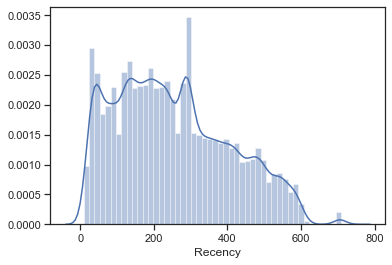

In [34]:
#Exploring distribution of Recency

import seaborn as sns
from matplotlib import pyplot as plt
sns.distplot(datamart['Recency'])
plt.show()

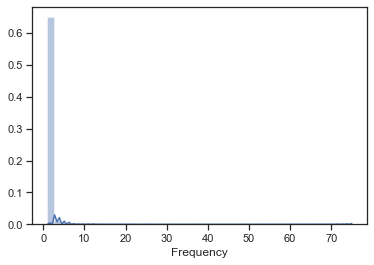

In [35]:
sns.distplot(datamart['Frequency'])
plt.show()

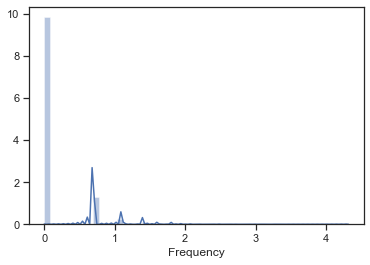

In [36]:
#managing skewness of frequency

frequency_log= np.log(datamart['Frequency'])
sns.distplot(frequency_log)
plt.show()

In [39]:
datamart.describe()

,Recency,Frequency,MonetaryValue,RFM_Score
count,95419.000000,95419.000000,95419.000000,95419.000000
mean,252.595406,1.232469,315.346687,6.002473
std,153.153422,0.823064,3243.986034,1.587735
min,10.000000,1.000000,9.590000,3.000000
25%,128.000000,1.000000,63.935000,5.000000
50%,233.000000,1.000000,113.860000,6.000000
75%,362.000000,1.000000,210.085000,7.000000
max,738.000000,75.000000,491906.880000,10.000000


In [50]:
datamart_rfm = datamart[['Recency','Frequency','MonetaryValue']]

In [51]:
datamart_rfm

,Recency,Frequency,MonetaryValue
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,125,1,141.90
0000b849f77a49e4a4ce2b2a4ca5be3f,128,1,27.19
0000f46a3911fa3c0805444483337064,551,1,86.22
0000f6ccb0745a6a4b88665a16c9f078,335,1,43.62
0004aac84e0df4da2b147fca70cf8255,302,1,196.89
0004bd2a26a76fe21f786e4fbd80607f,160,1,166.98
00050ab1314c0e55a6ca13cf7181fecf,145,1,35.38
00053a61a98854899e70ed204dd4bafe,196,2,1257.54
0005e1862207bf6ccc02e4228effd9a0,557,1,150.12


In [53]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(datamart_rfm)
datamart_normalized = scaler.transform(datamart_rfm)

In [54]:
print('mean: ', datamart_normalized.mean(axis=0).round(2))
print('std: ', datamart_normalized.std(axis=0).round(2))

mean:  [ 0.  0. -0.]
std:  [1. 1. 1.]


In [58]:
datamart_normalized = pd.DataFrame(datamart_normalized, index=datamart_rfm.index, columns=datamart_rfm.columns)

In [59]:
print(datamart_normalized.describe().round(2))

        Recency  Frequency  MonetaryValue
count  95419.00   95419.00       95419.00
mean     252.60       1.23         315.35
std      153.15       0.82        3243.99
min       10.00       1.00           9.59
25%      128.00       1.00          63.94
50%      233.00       1.00         113.86
75%      362.00       1.00         210.08
max      738.00      75.00      491906.88


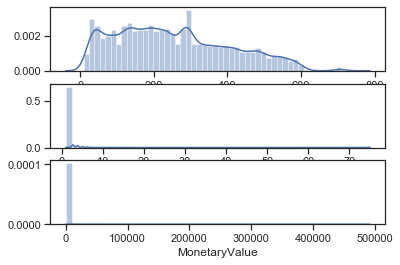

In [60]:
# Plot recency distribution
plt.subplot(3, 1, 1); sns.distplot(datamart_normalized['Recency'])

# Plot frequency distribution
plt.subplot(3, 1, 2); sns.distplot(datamart_normalized['Frequency'])

# Plot monetary value distribution
plt.subplot(3, 1, 3); sns.distplot(datamart_normalized['MonetaryValue'])

# Show the plot
plt.show()

In [68]:
datamart_rfm.head()


,Recency,Frequency,MonetaryValue
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,125,1,141.90
0000b849f77a49e4a4ce2b2a4ca5be3f,128,1,27.19
0000f46a3911fa3c0805444483337064,551,1,86.22
0000f6ccb0745a6a4b88665a16c9f078,335,1,43.62
0004aac84e0df4da2b147fca70cf8255,302,1,196.89


In [69]:
datamart_normalized.head()

,Recency,Frequency,MonetaryValue
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,125,1,141.90
0000b849f77a49e4a4ce2b2a4ca5be3f,128,1,27.19
0000f46a3911fa3c0805444483337064,551,1,86.22
0000f6ccb0745a6a4b88665a16c9f078,335,1,43.62
0004aac84e0df4da2b147fca70cf8255,302,1,196.89


In [61]:
# Import KMeans 
from sklearn.cluster import KMeans  

# Initialize KMeans
kmeans = KMeans(n_clusters=3, random_state=1) 

# Fit k-means clustering on the normalized data set
kmeans.fit(datamart_normalized)

# Extract cluster labels
cluster_labels = kmeans.labels_

In [62]:
# Create a DataFrame by adding a new cluster label column
datamart_rfm_k3 = datamart_rfm.assign(Cluster=cluster_labels)

# Group the data by cluster
grouped = datamart_rfm_k3.groupby(['Cluster'])

# Calculate average RFM values and segment sizes per cluster value
grouped.agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count']
  }).round(1)

Recency Frequency MonetaryValue       
           mean      mean          mean  count
Cluster                                       
0         252.6       1.2         275.3  95388
1         311.7      16.0      476533.0      3
2         220.5      11.2       85736.4     28

In [64]:
# Fit KMeans and calculate SSE for each *k*
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(datamart_normalized)
    sse[k] = kmeans.inertia_ # sum of squared distances to closest cluster center

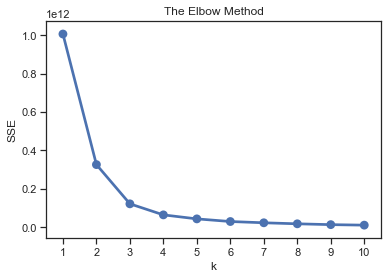

In [65]:
# Plot SSE for each *k*
plt.title('The Elbow Method')
plt.xlabel('k'); plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

In [66]:
# Initialize KMeans
kmeans = KMeans(n_clusters=2, random_state=1) 

# Fit k-means clustering on the normalized data set
kmeans.fit(datamart_normalized)

# Extract cluster labels
cluster_labels = kmeans.labels_

datamart_rfm_k2 = datamart_normalized.assign(Cluster=cluster_labels)

# Group the data by cluster
grouped = datamart_rfm_k2.groupby(['Cluster'])

# Calculate average RFM values and segment sizes per cluster value
grouped.agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count']
  }).round(1)




Recency Frequency MonetaryValue       
           mean      mean          mean  count
Cluster                                       
0         252.6       1.2         300.4  95416
1         311.7      16.0      476533.0      3

In [67]:
kmeans = KMeans(n_clusters=3, random_state=1) 

# Fit k-means clustering on the normalized data set
kmeans.fit(datamart_normalized)

# Extract cluster labels
cluster_labels = kmeans.labels_

datamart_rfm_k_3 = datamart_normalized.assign(Cluster=cluster_labels)

# Group the data by cluster
grouped = datamart_rfm_k_3.groupby(['Cluster'])

# Calculate average RFM values and segment sizes per cluster value
grouped.agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count']
  }).round(1)


Recency Frequency MonetaryValue       
           mean      mean          mean  count
Cluster                                       
0         252.6       1.2         275.3  95388
1         311.7      16.0      476533.0      3
2         220.5      11.2       85736.4     28

In [72]:
#Transform datamart_normalized as DataFrame and add a Cluster column

datamart_normalized = pd.DataFrame(datamart_normalized, 
                                   index=datamart_rfm.index, 
                                   columns=datamart_rfm.columns)
datamart_normalized['Cluster'] = datamart_rfm_k3['Cluster']

In [74]:
#Melt the data into a long format so RFM values and metric names are stored in 1 column each



datamart_melt = pd.melt(datamart_normalized.reset_index(), 
                    id_vars=['customer_unique_id', 'Cluster'],
                    value_vars=['Recency', 'Frequency', 'MonetaryValue'], 
                    var_name='Attribute', 
                    value_name='Value')

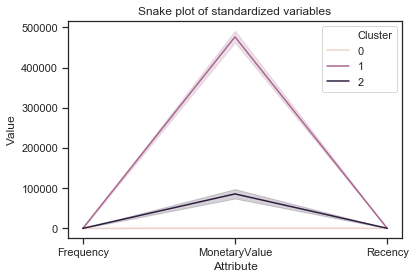

In [75]:
plt.title('Snake plot of standardized variables')
sns.lineplot(x="Attribute", y="Value", hue='Cluster', data=datamart_melt)

In [76]:
#method 2 to interpret segments

cluster_avg = datamart_rfm_k3.groupby(['Cluster']).mean() 

population_avg = datamart_rfm.mean()

relative_imp = cluster_avg / population_avg - 1

In [77]:
relative_imp.round(2) 

,Cluster,Frequency,MonetaryValue,Recency
Cluster,,,,
0,NaN,-0.00,-0.13,0.00
1,NaN,11.98,1510.14,0.23
2,NaN,8.13,270.88,-0.13


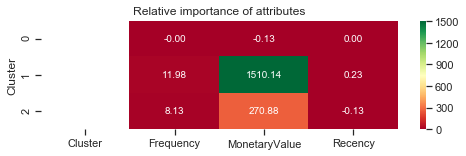

In [78]:
plt.figure(figsize=(8, 2))
plt.title('Relative importance of attributes')
sns.heatmap(data=relative_imp, annot=True, fmt='.2f', cmap='RdYlGn')
plt.show()

In [79]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(datamart_normalized[['Frequency']])
datamart_normalized['FrequencyCluster'] = kmeans.predict(datamart_normalized[['Frequency']])

In [82]:
datamart_normalized.groupby('FrequencyCluster')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,81088.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
1,1615.0,4.773375,1.042782,4.0,4.0,4.0,5.0,8.0
2,12593.0,2.154133,0.361091,2.0,2.0,2.0,2.0,3.0
3,114.0,12.087719,3.104554,9.0,10.0,11.0,13.0,22.0
4,9.0,33.222222,16.513463,24.0,24.0,26.0,35.0,75.0


In [83]:
#building 5 clusters for recency and adding it to dataframe
kmeans = KMeans(n_clusters=5)
kmeans.fit(datamart_normalized[['Recency']])
datamart_normalized['RecencyCluster'] = kmeans.predict(datamart_normalized[['Recency']])

In [84]:
datamart_normalized.groupby('FrequencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,81088.0,252.375493,153.359555,14.0,128.0,233.0,362.0,738.0
1,1615.0,257.312693,156.142504,15.0,128.0,237.0,363.0,708.0
2,12593.0,253.362662,151.426657,10.0,130.0,234.0,361.0,738.0
3,114.0,250.394737,150.593141,21.0,133.0,236.0,351.0,603.0
4,9.0,341.777778,179.279654,35.0,210.0,400.0,462.0,550.0


In [85]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(datamart_normalized[['MonetaryValue']])
datamart_normalized['RevenueCluster'] = kmeans.predict(datamart_normalized[['MonetaryValue']])

In [86]:
datamart_normalized.groupby('RevenueCluster')['MonetaryValue'].describe()

,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,94917.0,223.354191,387.442161,9.59,63.6400,113.29,207.57,4968.90
1,3.0,476532.960000,14747.509150,462504.00,468846.0000,475188.00,483547.44,491906.88
2,12.0,117980.595833,23467.227351,93960.00,97646.4975,111043.41,130581.48,166023.00
3,452.0,9747.361128,5029.362201,4972.44,5972.1750,7820.82,11811.99,27471.78
4,35.0,46822.356286,16061.011870,28380.24,34297.8300,40939.92,61697.28,79205.50


In [88]:
datamart_normalized['OverallScore'] = datamart_normalized['RecencyCluster'] + datamart_normalized['FrequencyCluster'] + datamart_normalized['RevenueCluster']
datamart_normalized.groupby('OverallScore')['Recency','Frequency','MonetaryValue'].mean()

,Recency,Frequency,MonetaryValue
OverallScore,,,
0,525.899086,1.000000,157.304554
1,170.373466,1.029336,162.372319
2,291.575281,1.135396,196.373188
3,81.962089,1.237471,236.425492
4,366.760809,1.293267,275.904608
5,93.735374,2.509864,1223.122908
6,383.508916,2.374943,1445.146397
7,163.160377,6.339623,13271.119245
8,287.735849,6.698113,19782.267358
